## Practical work #1: Blind Source Separation - statistical approaches
#### _Author: Hugo Simon_

We strongly advise to use this notebook for these practical works.
Participants that opt for Python will find the following modules helpful: 
- ipython
- scipy/numpy
- matplotlib
- scikit-learn
- scikit-image
- astropy
- pytorch

Please note that for python codes, all the necessary routines are contained in the module pyBSS.py
Most of them can be set up with easily using standard porting tools (apt-get, macport ... etc).
All the necessary material is available at \url{http://jerome-bobin.fr/teaching/master-2-mva/}}

In [2]:
import codes.pyBSS as pb
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyf
import codes.Starlet2D as st2
import torch
import scipy.io as sio
%matplotlib inline

## PART I - Independent Component Analysis
### Data generation and second-order statistics
The goal of the first part is to familiarize yourself with the statistical basics of Blind Source Separation and more particularly Independent Component Analysis. The journey will start with simple second-order statistics.

### Step I - Data generation and visualisation

The function _GenerateMixture_ of the pyBSS module allows to generate sources with identically and independently distributed entries. The function works as follows:

*X,A,S = pb.GenerateMixture(n=n,t=t,m=m,SType=1,CdA=1)*

where n is the number of sources, t the number of samples per source and SType stands for the type of sources (1: Gaussian, 2: Uniform, 3: Sparse). The parameter CdA is the condition number of the mixing matrix. The outputs are the mixtures, the mixing matrix and the sources.

##### **To be done #1: Generate 2 sources of different types and 2 mixtures. Visualise their respective scatter plots and comment. From a statistical viewpoint, to which quantity correspond the scatter plot ?**
$\hookrightarrow$ Scatter plot corresponds to the joint distribution

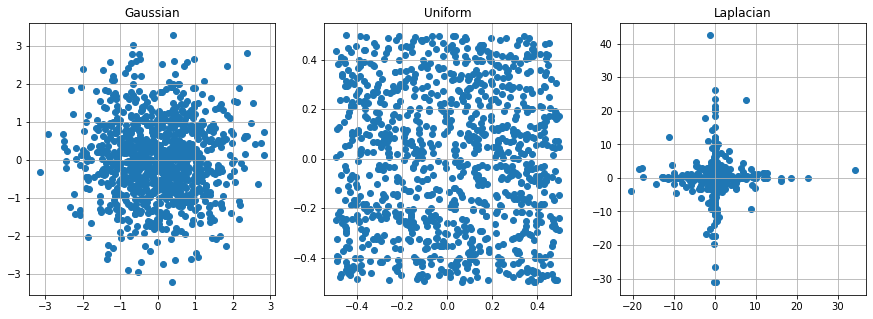

In [63]:
n, t, m = 2, 1000, 2
plot_name = ["Gaussian", "Uniform", "Laplacian"]
nb_plot = len(plot_name)

plt.figure(figsize=(15,5))
Xs, As, Ss = [], [], []
for i in range(nb_plot):
    X,A,S = pb.GenerateMixture(n=n,t=t,m=m,SType=i+1,CdA=1)
    Xs.append(X), As.append(A), Ss.append(S)
    plt.subplot(1,nb_plot,i+1)
    plt.scatter(Ss[i][0], Ss[i][1])
    plt.title(plot_name[i])
    plt.grid(), 
plt.show();

### Step II - Second-order statistics

##### **To be done #2: implement a code that performs the Principal Component Analysis, apply it to the 3 previously generated mixtures, visualise the results and comment.**

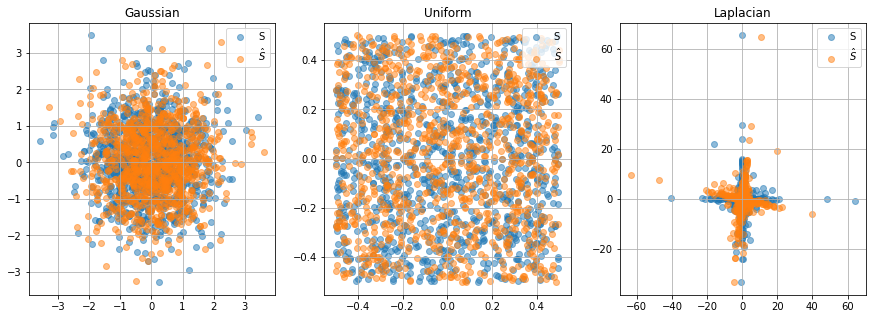

In [3]:
plt.figure(figsize=(15,5))
for i in range(nb_plot):
    X, S = Xs[i], Ss[i]
    _, eigvec = np.linalg.eigh(X @ X.T) # more stable than svd
    S_hat = eigvec.T[::-1][:n] @ X    
    
    plt.subplot(1,nb_plot,i+1)
    plt.scatter(S[0], S[1], alpha=0.5, label="S")
    plt.scatter(S_hat[0], S_hat[1], alpha=0.5, label="$\hatS$")
    plt.title(plot_name[i])
    plt.legend(), plt.grid(), 
plt.show();

### From second-order statistics to statistical independence
### Step III - From second-order statistics to statistical independence

The python module scikit-learn (sklearn) contains an implementation of the fastica algorithm, an efficient ICA algorithm building upon a deflation-based optimisation procedure.

##### **To be done #3: apply the fastica algorithm to the 3 previously generated mixtures, visualise the results and comment.**

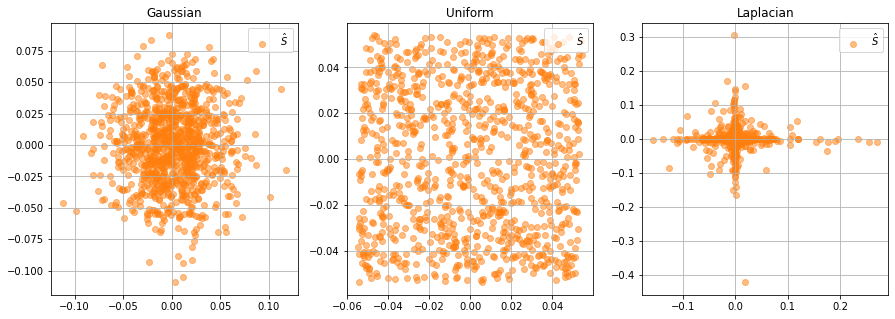

In [7]:
from sklearn.decomposition import FastICA
plt.figure(figsize=(15,5))
ica = FastICA(n_components=2)
for i in range(nb_plot):
    X, S = Xs[i], Ss[i]
    ica.fit(X.T)
    S_hat = ica.transform(X.T).T
    plt.subplot(1,nb_plot,i+1)
    # plt.scatter(S[0], S[1], alpha=0.5, label="S")
    plt.scatter(S_hat[0], S_hat[1], alpha=0.5, label="$\hatS$", color='C1')
    plt.title(plot_name[i])
    plt.legend(), plt.grid(), 
plt.show();

A key element in a large number of applications of ICA is robustness to additive noise.

##### **To be done #4:**
**1. Implement a code that generates mixtures with known signal-to-noise (SNR) level.**

**2. Apply the fastica algorithm to the mixtures (uniform or sparse), display a plot to show the evolution of the estimation quality (with your preferred metric) as a function of the SNR and comment.**

*Tip: since the result of the fastica algorithm will depend on the noise realisation and initialisation, it might be interesting to average the results across various Monte-Carlo simulations corresponding to different noise realisations.*

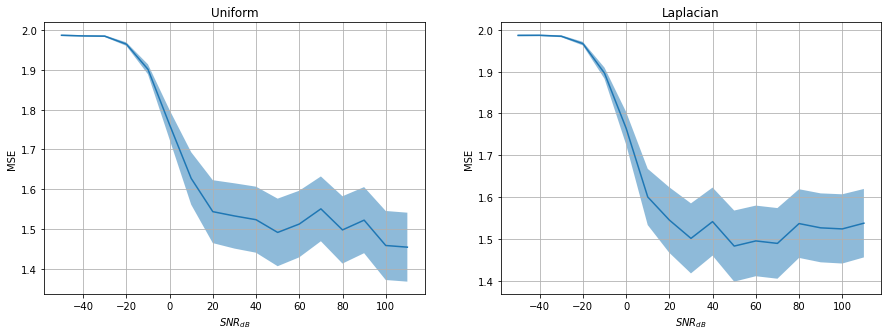

In [22]:
from sklearn.decomposition import FastICA
import warnings
warnings.filterwarnings('ignore')

plot_name = ["Uniform", "Laplacian"]
nb_plot = len(plot_name)
nb_reprod = 1000
SNRs = np.arange(-50,111,10)

plt.figure(figsize=(15,5))
errors = np.zeros((len(SNRs), nb_reprod))
ica = FastICA(n_components=2, max_iter=1000)
for i in range(nb_plot):
    plt.subplot(1,nb_plot,i+1)
    for j, SNR in enumerate(SNRs):
        for reprod in range(nb_reprod):
            X,A,S = pb.GenerateMixture(n=n,t=t,m=m,SType=i+2,CdA=1, noise_level=SNR)
            ica.fit(X.T)
            S_hat = ica.transform(X.T).T
            
            Sm = S / np.linalg.norm(S, axis=-1)[:,None]
            Sm_hat = S_hat / np.linalg.norm(S_hat, axis=-1)[:,None]
            Sm_hat_perm = Sm_hat[[1,0]]        
            
            mse = np.linalg.norm(Sm_hat - Sm)
            mse_perm = np.linalg.norm(Sm_hat_perm - Sm)
            errors[j,reprod] = min(mse, mse_perm)
    
    mean_errors, std_errors = errors.mean(axis=-1), errors.std(axis=-1)
    plt.plot(SNRs, mean_errors)
    k_std = 0.1 
    plt.fill_between(SNRs, mean_errors+k_std*std_errors, mean_errors-k_std*std_errors, alpha=0.5)
    plt.xlabel("$SNR_{dB}$"), plt.ylabel("MSE")
    plt.title(plot_name[i]), plt.grid(), 
plt.show();

##### **To be done #5:**
**Propose and implement a protocol to test the equivariance property of FastICA.**


$\hookrightarrow$  An ICA method $\mathcal{M}(\cdot): \mathbb{R}^{d \times N} \rightarrow \mathbb{R}^{d \times d}$ that estimates $\mathbf{H}^{-1}$ is called affine equivariant if $\mathcal{M}(\mathbf{R Y})=\mathcal{M}(\mathbf{Y}) \mathbf{R}^{-1}$ up to signs and permutation for any full-rank matrix $\mathbf{R} \in \mathbb{R}^{d \times d}$, where $\mathbf{Y}=(\mathbf{y}(1), \ldots, \mathbf{y}(N))$ is the matrix of the observed signals.

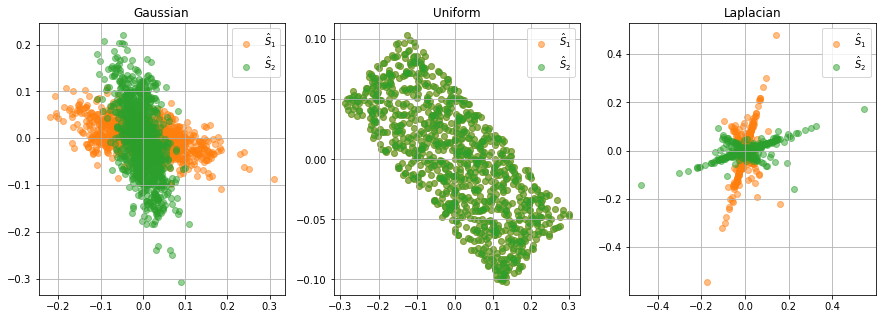

In [192]:
plot_name = ["Gaussian", "Uniform", "Laplacian"]
nb_plot = len(plot_name)
plt.figure(figsize=(15,5))
ica = FastICA(n_components=2)
for i in range(nb_plot):
    X, S = Xs[i], Ss[i]
    
    transform = np.random.randn(m,m)
    ica.fit((transform @ X).T)
    S_hat1 = ica.transform(X.T).T
    ica.fit(X.T)
    S_hat2 = ica.transform((np.linalg.inv(transform) @ X).T).T
    
    plt.subplot(1,nb_plot,i+1)
    plt.scatter(S_hat1[0], S_hat1[1], alpha=0.5, color='C1', label="$\hatS_1$")
    plt.scatter(S_hat2[0], S_hat2[1], alpha=0.5, color='C2', label="$\hatS_2$")
    plt.title(plot_name[i])
    plt.legend(), plt.grid(), 
plt.show();

$\hookrightarrow$ Sources recovered are the same up to sign and permutation. This illustrates FastICA equivariance property.

### Step IV - Application to astrophysical data

The data folder contains 2 datasets of astrophysical sources: "synthetic.npy" and "chandra.npy" _(which can be loaded with the load function from numpy)_.

Each file contains a numpy dict with one or two of these items: "X": the mixtures and "S" the input sources.

##### **To be done #6: apply the fastica algorithm to the 2 mixtures, visualise the results and comment.**

In [3]:
synthetic = np.load("data/synthetic.npy", allow_pickle=True).item()
chandra = np.load("data/chandra.npy", allow_pickle=True).item()

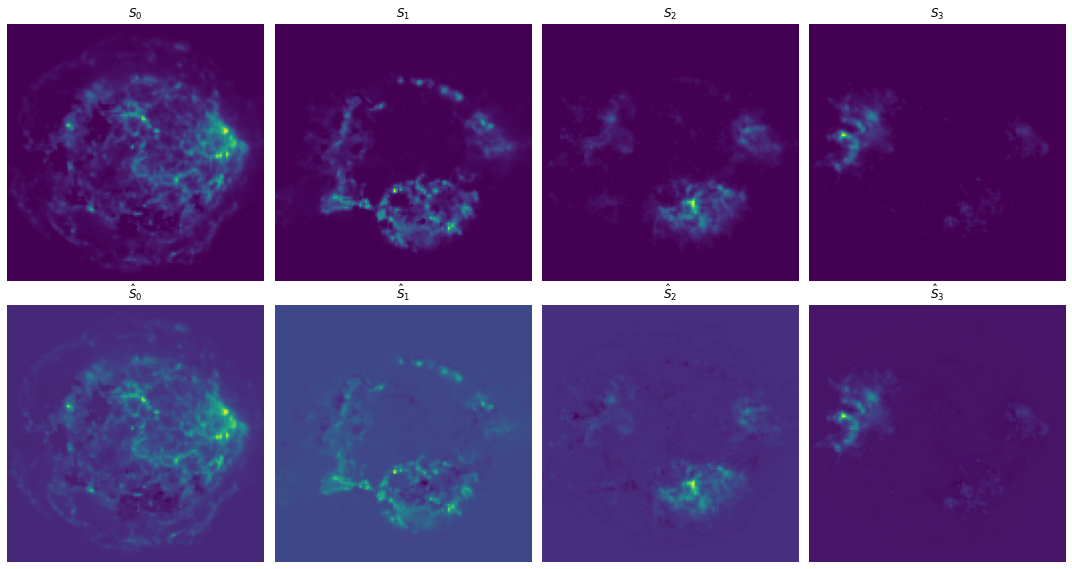

In [281]:
plt.figure(figsize=(15,8))

X, S = chandra['X'], chandra['S']
n = len(S)
ica = FastICA(n_components=nb_components)

X = X.reshape(len(X),-1)
ica.fit(X.T)
S_hat = (ica.transform(X.T).T).reshape(S.shape)

for i in range(n):
    plt.subplot(2,n,i+1)
    plt.imshow(S[i]), plt.axis("off")  
    plt.title(f"$S_{i}$")
    plt.subplot(2,n,i+5)
    plt.imshow(S_hat[i]), plt.axis("off")       
    plt.title(f"$\hatS_{i}$")
plt.tight_layout()

## BSS, the sparse way !

### Step V - Getting a sparse representation

The module pyStarlet contains functions to compute the starlet transform of 1D and 2D signals and its inverse transform. For instance, the forward transform for 2D signals applies as follows:

*c,w = Starlet_Forward2D(x,J=J)*

where x is the input imageand J the number of wavelet scales. The outputs are c, the coarse scale approximation and w the different wavelet scales.

##### **To be done #7: apply the Starlet transfrom to one of the previously used astronomical image, visualise the results and comment.**

In [17]:
X.shape

(50, 128, 128)

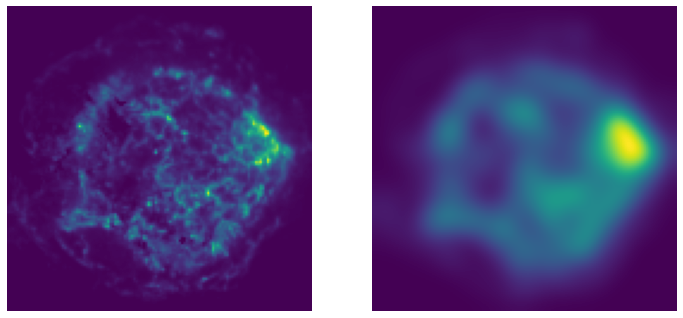

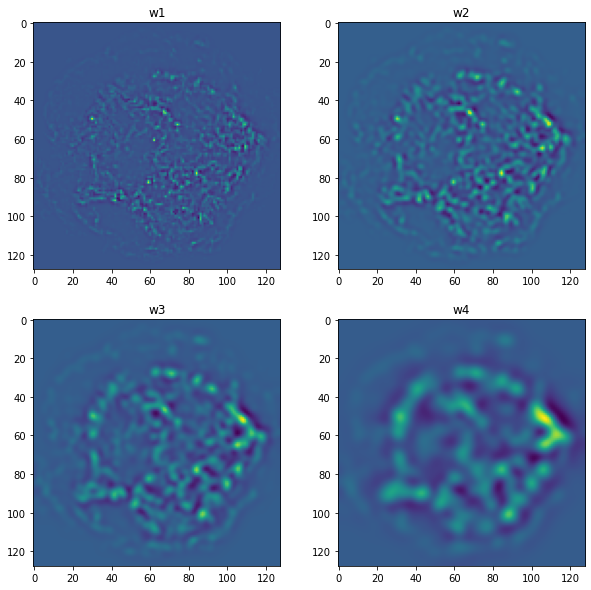

In [19]:
from codes.Starlet2D import Starlet_Forward2D

X, S = chandra['X'], chandra['S']
c,w = Starlet_Forward2D(X[0],J=4)

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(X[0]), plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(c), plt.axis("off");

fig, axs = plt.subplots(2, 2, figsize = (10, 10))
axs[0, 0].imshow(w[:,:,0])
axs[0, 0].set_title('w1')

axs[0, 1].imshow(w[:,:,1])
axs[0, 1].set_title('w2')

axs[1, 0].imshow(w[:,:,2])
axs[1, 0].set_title('w3')

axs[1, 1].imshow(w[:,:,3])
axs[1, 1].set_title('w4')

plt.show()

##### **To be done #8:** 
- Build a thresholding-based denoiser in the starlet domain. Apply it to one of the aforementioned astronomical images.
- How would you choose the value of the threshold ?

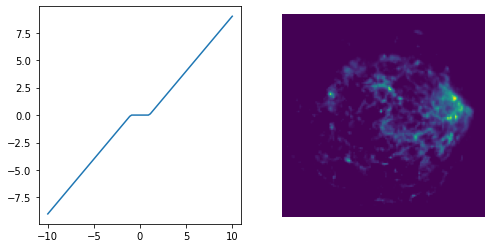

In [62]:
a = np.linspace(-10,10,100)
def soft_thresholding(x, lambd=0):
    return np.maximum(0,x-lambd) + np.minimum(0,x+lambd)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(a, soft_thresholding(a, 1));

X, S = chandra['X'], chandra['S']
from scipy.stats import median_abs_deviation
S_shape = S.shape
S = S.reshape(S_shape[0], -1)
lambds = 3*median_abs_deviation(S, axis=-1)
S_thr = soft_thresholding(S.T, lambds).T.reshape(S_shape)
plt.subplot(1,2,2)
plt.imshow(S_thr[0]), plt.axis("off");

### Step VI - the GMCA algorithm

##### **To be done #9:**
- Could you explain the concept of "morphological diversity", on which the GMCA algorithm is built ?
- Could you please derive the equations that describe the updates of the GMCA algorithm ?
- implement the GMCA algorithm, assuming that the input are already sparsely represented (no need to include a sparsifying transform).

$\hookrightarrow$ Morphological diversity is the assumption that the sources we look for are sparse in a different representation or dictionary.

In [145]:
X, S = chandra['X'], chandra['S']
X = X.reshape(len(X), -1)
m, t, n = *X.shape, len(S)
nb_iter = 10

# init
S_hat = np.ones((n, t))
# loop
for l in range(nb_iter):
    A_hat = X @ np.linalg.pinv(S_hat)
    A_norm = np.linalg.norm(A_hat, axis=0)
    for i in range(n):
        if A_norm[i] > 1:
            A_hat[:,i] = A_hat[:,i] / A_norm[i]
            
    S_hat = np.linalg.pinv(A_hat) @ X
    k = (3 * l + 7) / (l + 1) # decreasing from 7 to 3
    lambds = k * median_abs_deviation(S_hat, axis=-1)
    S_hat = soft_thresholding(S_hat.T, lambds).T
    
S_hat = S_hat.reshape(S.shape)

##### **To be done #10: Apply the GMCA algorithm the astronomical data introduced in step IV. visualise and comment.**

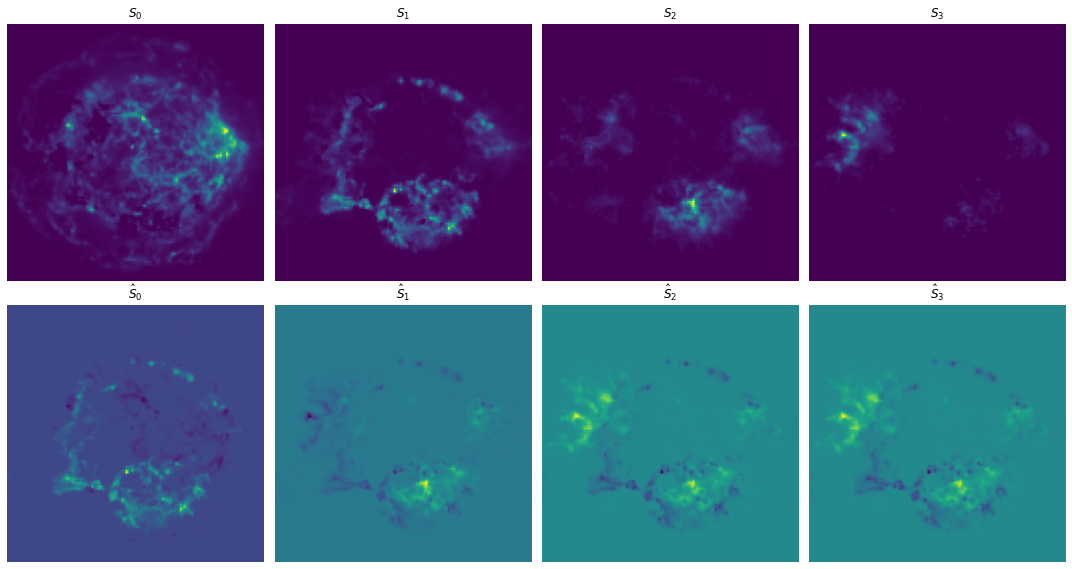

In [146]:
plt.figure(figsize=(15,8))
for i in range(n):
    plt.subplot(2,n,i+1)
    plt.imshow(S[i]), plt.axis("off")  
    plt.title(f"$S_{i}$")
    plt.subplot(2,n,i+5)
    plt.imshow(S_hat[i]), plt.axis("off")       
    plt.title(f"$\hatS_{i}$")
plt.tight_layout()

That's all for this practical work session. The next one will focus on proximal algorithm and their application to sparse BSS.